
#**DEEP LEARNING - MIGUEL MARINES**
##**<u>Fully Connected Deep Neural Network</u>**
---
---

#### Implementation of a Fully Connected Network for Kaggle ASL Dataset

The aim of this activity is to implement a multilayer network for the [Kaggle ASL (American Sign Language) Dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet).

In [ ]:
# Google Drive in Google Colab.
# Access to files and directories stored in Google Drive from a Colab notebook.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Libraries
import numpy as np                # Operations with multidimensional arrays and mathematical functions.
import string                     # Text manipulation.
import pandas as pd               # Manipulation and analysis of structured data (DataFrames).
import matplotlib.pyplot as plt   # Data visualization.
import cv2 as cv                  # Image processing.
import os                         # Interaction with the operating system and file path manipulation.

### **Import Data**

In [ ]:
# File Upload

DATA_PATH = '/content/drive/MyDrive/Deep_Learning/asl_data'               # Path to the dataset.

train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))   # Load training data.
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))   # Load validation data.

In [ ]:
train_df.head()   # Display the first 5 rows of the DataFrame.

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### **Validation and Test Split**

In [ ]:
y_train = np.array(train_df['label'])         # Convert the 'label' column from the training set into a NumPy array.
y_val = np.array(valid_df['label'])           # Convert the 'label' column from the validation set into a NumPy array.

del train_df['label']                         # Remove the 'label' column from the training DataFrame.
del valid_df['label']                         # Remove the 'label' column from the validation DataFrame.

x_train = train_df.values.astype(np.float32)  # Convert the remaining training data to a NumPy array of type float32.
x_val = valid_df.values.astype(np.float32)    # Convert the remaining validation data to a NumPy array of type float32.

In [ ]:
# Validation and Test Split Function
def split_val_test(x, y, pct=0.5, shuffle=True):

    n = x.shape[0]                  # Get the number of samples.
    indices = np.arange(n)          # Generate indices.

    if shuffle:                     # Shuffle the indices if required.
        np.random.shuffle(indices)

    split_idx = int(n * (1 - pct))  # Calculate the split index.

    # Split the data into validation and test sets based on the split index.
    val_idx, test_idx = indices[:split_idx], indices[split_idx:]

    x_val, x_test = x[val_idx], x[test_idx]  # Split x into validation and test sets using the indices.
    y_val, y_test = y[val_idx], y[test_idx]  # Split y into validation and test sets using the indices.

    return x_val, y_val, x_test, y_test

In [ ]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val) # Split validation and test sets.

### **Alphabet**

In [ ]:
# Remove letters 'j' and 'z' from the alphabet list.
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### **Normalise**

In [ ]:
# Normalise Function.
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [ ]:
x_mean = x_train.mean()  # Calculate the mean of the training data.
x_std = x_train.std()    # Calculate the standard deviation of the training data.

x_train = normalise(x_mean, x_std, x_train)  # Normalize the training data using the mean and std.
x_val = normalise(x_mean, x_std, x_val)      # Normalize the validation data using the training mean and std.
x_test = normalise(x_mean, x_std, x_test)    # Normalize the test data using the training mean and std.

### **Plot Samples**

In [ ]:
# Function to display images.
def plot_image(image):
    plt.figure(figsize=(5, 5))
    # Display image in a 2D array format and reshape the image to 28x28 for visualization.
    plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

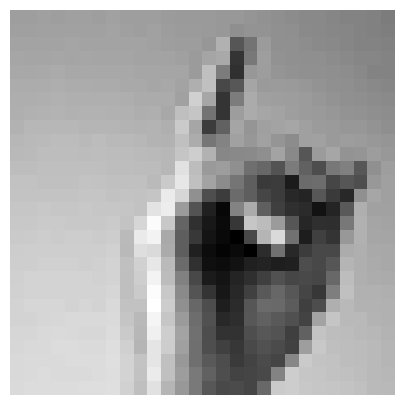

The image shown represents in sign language the letter: d


In [ ]:
# Image Sample
rnd_idx = np.random.randint(len(y_test))  # Select randomly an index from the y_test array.
plot_image(x_test[rnd_idx])  # Display the randomly selected test image using the plot_image function.
print(f'The image shown represents in sign language the letter: {alphabet[y_test[rnd_idx]]}') # Print the label of the randomly selected test image.

### **Ecuations for the Model**


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### **Mini Batches**

In [ ]:
# Function to create minibatches.
def create_minibatches(mb_size, x, y, shuffle=True):

    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'  # Ensure the number of samples in x and y are equal.

    total_data = x.shape[0] # Get the total number of data samples.

    # Shuffle the indices if required.
    if shuffle:
        idxs = np.arange(total_data)  # Create an array of indices for all data samples.
        np.random.shuffle(idxs) # Shuffle the indices if shuffle is True.
        x = x[idxs] # Shuffle x based on the shuffled indices.
        y = y[idxs] # Shuffle y based on the shuffled indices.

    # Return a generator that yields minibatches of size mb_size from x and y.
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## **Linear, ReLU, Sequential, and SoftMax-Entropy Classes**

###  **Linear Class**

In [ ]:
class Linear():

    # Input
    def __init__(self, input_size, output_size):
        # Initialize weights (W) and biases (b) for the layer with random values.
        # Weight matrix W has shape (output_size, input_size) and is scaled for initialization.
        # Bias vector b has shape (output_size, 1) and is initialized to zeros.
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    # Forward Pass
    def __call__(self, X):
        # Compute the linear transformation.
        Z = self.W @ X + self.b
        return Z

    # Backward Pass (For Gradient Calculation)
    def backward(self, X, Z):
        # Compute gradients for input X, weights W, and biases b.
        X.grad = self.W.T @ Z.grad  # Gradient of the loss (input X).
        self.W.grad = Z.grad @ X.T  # Gradient of the loss (weights W).
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)  # Gradient of the loss (biases b).

### **ReLU Class**

In [ ]:
class ReLU():

    # Forward Pass
    def __call__(self, Z):
        # Apply the ReLU activation function.
        return np.maximum(0, Z)

    # Backward Pass
    def backward(self, Z, A):
        # Copies the gradient from A to Z.
        # Grad and zeroes out gradients where Z <= 0.
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### **Sequential Class**

In [ ]:
class Sequential_layers():

    # Input
    def __init__(self, layers):
        # Initialize the sequence of layers and stores them in a list.
        self.layers = layers
        self.x = None         # Placeholder for input.
        self.outputs = {}     # Dictionary to store intermediate layer outputs.

    # Forward Pass
    def __call__(self, X):
        # Pass input through each layer sequentially and stores intermediate outputs.
        self.x = X
        self.outputs['l0'] = self.x                   # Store input as first output.
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)                    # Apply each layer to the current input.
            self.outputs['l'+str(i)] = self.x         # Store output of each layer.
        return self.x

    # Backward Pass
    def backward(self):
        # Perform backpropagation through each layer in reverse order.
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    # Gradient Update
    def update(self, learning_rate=1e-3):
        # Update weights and biases of linear layers using gradient descent.
        for layer in self.layers:
            if isinstance(layer, ReLU): continue  # Skip ReLU as it has no parameters.
            layer.W = layer.W - learning_rate * layer.W.grad  # Update weights.
            layer.b = layer.b - learning_rate * layer.b.grad  # Update biases.

    # Prediction
    def predict(self, X):
        # Perform a forward pass and return the class with the highest score (argmax).
        return np.argmax(self.__call__(X))

### **Cost Function**

In [ ]:
# Cost Function
def softmax_entropy(x, y):

    batch_size = x.shape[1]                      # Get the batch size from the input.

    exp_scores = np.exp(x)                       # Compute the exponentials of the input scores (for softmax).
    probs = exp_scores / exp_scores.sum(axis=0)  # Compute softmax probabilities for each class.
    preds = probs.copy()                         # Copy probabilities to use as predictions.

    # Compute the cross-entropy cost (loss function).
    y_hat = probs[y.squeeze(), np.arange(batch_size)]  # Get predicted probabilities for the true labels.
    cost = np.sum(-np.log(y_hat)) / batch_size         # Calculate the average cross-entropy loss.

    # Calculate gradients for backpropagation.
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # Gradient of the loss input x.
    x.grad = probs.copy()                           # Store the gradient in x.

    return preds, cost  # Return predicted probabilities and the cost.

## **Model**

### **Accuracy**

In [ ]:
class np_tensor(np.ndarray): pass # Define a custom class that behaves exactly like np.ndarray without adding any new functionality.

In [ ]:
# Accuracy Functiion
def accuracy(x, y, mb_size):

    correct = 0  # Initialize counter for correct predictions.
    total = 0    # Initialize counter for total predictions.

    # Iterate over minibatches of the input data.
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))  # Get model predictions for the current minibatch.

        # Count correct predictions (where predicted class equals true label).
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

        # Update the total number of predictions made.
        total += pred.shape[1]

    # Return the accuracy as the ratio of correct predictions to total predictions.
    return correct / total

### **Model and Training**

The model architecture presented is designed for the Kaggle ASL Dataset, where each input is a flattened 28x28 image, resulting in 784 input features. The architecture consists of four linear layers with progressively decreasing neurons (512, 256, 128) and ReLU activations. The rationale behind these choices is to capture complex patterns and hierarchical representations in the data.

The first layer, which maps the 784 input features to 512 neurons, allows for capturing a large number of high-dimensional features from the input images. The following layers (512 → 256 → 128) progressively reduce the dimensionality, which helps the model focus on more abstract, refined features and mitigates overfitting by limiting the number of neurons. ReLU is chosen as the activation function because it introduces non-linearity, allowing the network to learn complex patterns, and helps with faster convergence compared to other functions.

The final layer maps the 128 neurons to 24 outputs, corresponding to the 24 distinct classes in the ASL dataset (excluding 'j' and 'z'). The minibatch size of 512 is chosen to balance memory efficiency and gradient stability. The learning rate of 1e-4 is relatively small, which helps ensure gradual learning and prevents large updates that could lead to instability. The training spans 15 epochs, which is sufficient to allow the model to learn but not overfit to the data. This architecture is designed to be deep enough to capture the complexities of hand gestures while maintaining computational efficiency.

In [ ]:
# Training Function
def train(model, epochs, mb_size=128, learning_rate=1e-3):

    for epoch in range(epochs):  # Iterate over the number of epochs.

        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):

            # Forward pass: calculate scores using the model.
            scores = model(x.T.view(np_tensor))

            # Compute the cost using softmax cross-entropy.
            _, cost = softmax_entropy(scores, y)

            # Backward pass: calculate gradients.
            model.backward()

            # Update model parameters using gradient descent.
            model.update(learning_rate)

        # At the end of each epoch, print the cost and validation accuracy.
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
# Model
model = Sequential_layers([
    Linear(784, 512),  # First layer: 784 input features to 512 neurons.
    ReLU(),
    Linear(512, 256),  # Second layer: 512 neurons to 256 neurons.
    ReLU(),
    Linear(256, 128),  # Third layer: 256 neurons to 128 neurons.
    ReLU(),
    Linear(128, 24)    # Output layer: 128 neurons to 24 classes (output).
])

mb_size = 512         # Minibatch size.
learning_rate = 1e-4  # Learning rate for the model update.
epochs = 15           # Number of training epochs.

In [ ]:
# Training
train(model, epochs, mb_size, learning_rate)

costo: 0.8514973224088795, accuracy: 0.5847741215839375
costo: 0.40337711853068875, accuracy: 0.6862799776910207
costo: 0.21117583860677813, accuracy: 0.7381483547127718
costo: 0.11336997580890489, accuracy: 0.7512548800892359
costo: 0.0748242656276629, accuracy: 0.7674288901282766
costo: 0.05204706555168195, accuracy: 0.7732849972113776
costo: 0.039829897188390244, accuracy: 0.7752370329057445
costo: 0.029941273601537494, accuracy: 0.7783045175683212
costo: 0.023787279895525384, accuracy: 0.7780256553262688
costo: 0.01973117936550624, accuracy: 0.7816508644729504
costo: 0.019670756739478004, accuracy: 0.7752370329057445
costo: 0.01167778005140374, accuracy: 0.7808142777467931
costo: 0.01269321031574743, accuracy: 0.7816508644729504
costo: 0.011722982156067159, accuracy: 0.7822085889570553
costo: 0.009824545405839569, accuracy: 0.7796988287785834


In [ ]:
print(accuracy(x_test, y_test, mb_size))  # Model Accuracy

0.7760736196319018


### **Test Model on Random Data From the Test Set**

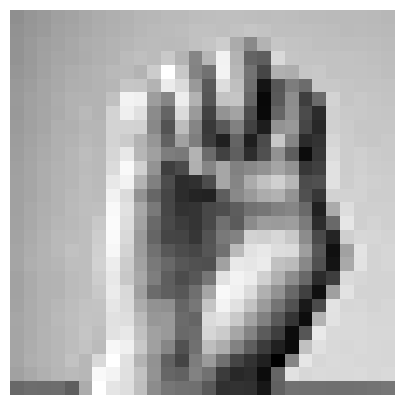

Based on the Image in Sign Language
The predicted letter is: e
The actual letter is: e


In [ ]:
idx = np.random.randint(len(y_test))                 # Select a random index from the test set.
plot_image(x_test[idx].reshape(28, 28))              # Plot the image from the test set at the selected index.

pred = model.predict(x_test[idx].reshape(-1, 1))     # Predict the letter by passing the reshaped image through the model.

# Print the predicted and actual letters.
print('Based on the Image in Sign Language')
print(f'The predicted letter is: {alphabet[pred]}')     # Convert the predicted class index to the corresponding letter.
print(f'The actual letter is: {alphabet[y_test[idx]]}')  # Convert the actual class index to the corresponding letter.